# Count tangles on a slide

In [6]:
# Prelims
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torch.cuda as cutorch
import timeit
import scipy.special
import sys
import openslide

# Import wildcat
sys.path.append("wildcat.pytorch")
import wildcat.models

# Import wildcat mods
from unet_wildcat import *

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
print("CUDA status: ", torch.cuda.is_available())
print("CUDA memory max alloc: %8.f MB" % (torch.cuda.max_memory_allocated() / 2.0**20))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

PyTorch Version:  1.0.0
Torchvision Version:  0.2.2
CUDA status:  True
CUDA memory max alloc:      288 MB
Device:  cuda:0


In [7]:
# Global properties
num_classes=2
input_size=224
input_size_wildcat=224
batch_size=16
batch_size_wildcat=16
resnet_flavor=18
fold = "fold_INDD119294"
data_dir = "/home/pyushkevich/data/thon2019/exp01/%s" % (fold,)
model_dir="/home/pyushkevich/resnet/thon2019/exp01/%s" % (fold,)

In [8]:
# Read the wildcat model
model_wildcat = resnet50_wildcat_upsample(2, pretrained=False, kmax=0.02, alpha=0.7, num_maps=4)
model_wildcat.load_state_dict(torch.load(os.path.join(model_dir, "model_%s_wcu_50_15epoch.dat" % (fold,))))

# Set evaluation mode
model_wildcat.eval()

# Send model to GPU
model_wildcat = model_wildcat.to(device)

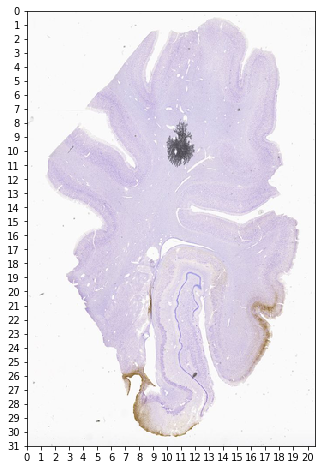

In [53]:
# Read a slide and show thumbnail
osl=openslide.OpenSlide('/home/pyushkevich/data/raw/HNL-33-18_HR3p_TAU_36.tif')
plt.figure(figsize=(16,8))
plt.imshow(osl.get_thumbnail((512,512)), extent=(0,osl.level_dimensions[0][0]/4096,osl.level_dimensions[0][1]/4096,0))
ax = plt.gca()
plt.xticks(np.arange(0,osl.level_dimensions[0][0]/4096));
plt.yticks(np.arange(0,osl.level_dimensions[0][1]/4096));

In [54]:
# Size of the training patch used to train wildcat, in raw pixels
patch_size_raw = 512

# Size of the window used to apply WildCat. Should be larger than the patch size
# This does not include the padding
window_size_raw = 4096

# The amount of padding, relative to patch size to add to the window. This padding
# is to provide context at the edges of the window
padding_size_rel = 1.0
padding_size_raw = int(padding_size_rel * patch_size_raw)

# Dimensions of the input image
slide_dim = np.array(osl.dimensions)

# Factor by which wildcat shrinks input images when mapping to segmentations
wildcat_shrinkage=2

# Additional shrinkage to apply to output (because we don't want to store very large)
# output images
extra_shrinkage=4

# Size of output pixel (in input pixels)
out_pix_size = wildcat_shrinkage * extra_shrinkage * patch_size_raw * 1.0 / input_size_wildcat

# The output size for each window
window_size_out = int(window_size_raw / out_pix_size)

# The padding size for the output
padding_size_out = int(padding_size_rel * patch_size_raw / out_pix_size)

# Total number of non-overlapping windows to process
n_win = np.ceil(slide_dim / window_size_raw).astype(int)

# Output image size 
out_dim=(n_win * window_size_out).astype(int)

# Output array (last dimension is per-class probabilities)
density=np.zeros((2, out_dim[0], out_dim[1]))

# Range of pixels to scan
u_range,v_range = (5,19),(19,31)
#u_range,v_range = (0,n_win[0]),(0,n_win[1])

# Range non-overlapping windows
t_00 = timeit.default_timer()
for u in range(u_range[0], u_range[1]):
    for v in range(v_range[0], v_range[1]):
        
        # Get the coordinates of the window in raw pixels
        x,y,w = u*window_size_raw,v*window_size_raw,window_size_raw
        
        # Subtract the padding
        xp,yp,wp = x-padding_size_raw,y-padding_size_raw,window_size_raw+2*padding_size_raw
        
        # Read the chunk from the image
        t0 = timeit.default_timer()
        chunk_img=osl.read_region((xp,yp), 0, (wp,wp)).convert("RGB")
        t1 = timeit.default_timer()
                
        # Compute the desired size of input to wildcat
        wwc = int(wp * input_size_wildcat / patch_size_raw)

        # Resample the chunk for the two networks
        tran = transforms.Compose([
            transforms.Resize((wwc,wwc)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
        # Convert the read chunk to tensor format
        with torch.no_grad():
            
            # Apply transforms and turn into correct-size torch tensor
            chunk_tensor=torch.unsqueeze(tran(chunk_img),dim=0).to(device)
            
            # Forward pass through the wildcat model
            x_clas = model_wildcat.forward_to_classifier(chunk_tensor)
            x_cpool = model_wildcat.spatial_pooling.class_wise(x_clas)

            # Scale the cpool image to desired size
            x_cpool_up = torch.nn.functional.interpolate(x_cpool, scale_factor=1.0/extra_shrinkage).detach().cpu().numpy()

            # Extract the central portion of the output
            p0,p1 = padding_size_out,(padding_size_out+window_size_out)
            x_cpool_ctr = x_cpool_up[:,:,p0:p1,p0:p1]
            
            # Stick it into the output array
            xout0,xout1 = u * window_size_out, ((u+1) * window_size_out)
            yout0,yout1 = v * window_size_out, ((v+1) * window_size_out)
            density[0,xout0:xout1,yout0:yout1] = x_cpool_ctr[0,0,:,:].transpose()
            density[1,xout0:xout1,yout0:yout1] = x_cpool_ctr[0,1,:,:].transpose()
                
        # Finished first pass through the chunk
        t2 = timeit.default_timer()
        
        # At this point we have a list of hits for this chunk
        print("Chunk: (%6d,%6d) Times: IO=%6.4f WldC=%6.4f Totl=%8.4f" %
              (u,v,t1-t0,t2-t1,t2-t0))
        
# Trim the density array to match size of input
out_dim_trim=np.round((slide_dim/out_pix_size)).astype(int)
density=density[:,0:out_dim_trim[0],0:out_dim_trim[1]]

/home/pyushkevich/miniconda3/envs/histo/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


Chunk: (     5,    19) Times: IO=1.6474 WldC=1.0117 Totl=  2.6592
Chunk: (     5,    20) Times: IO=1.7097 WldC=0.9586 Totl=  2.6683
Chunk: (     5,    21) Times: IO=1.6429 WldC=0.9943 Totl=  2.6371
Chunk: (     5,    22) Times: IO=1.6790 WldC=0.9600 Totl=  2.6391
Chunk: (     5,    23) Times: IO=1.6048 WldC=0.9944 Totl=  2.5992
Chunk: (     5,    24) Times: IO=1.6053 WldC=0.9607 Totl=  2.5661
Chunk: (     5,    25) Times: IO=1.5602 WldC=0.9945 Totl=  2.5546
Chunk: (     5,    26) Times: IO=1.6057 WldC=0.9607 Totl=  2.5663
Chunk: (     5,    27) Times: IO=1.5478 WldC=0.9971 Totl=  2.5449
Chunk: (     5,    28) Times: IO=1.6063 WldC=0.9594 Totl=  2.5657
Chunk: (     5,    29) Times: IO=1.5739 WldC=0.9985 Totl=  2.5724
Chunk: (     5,    30) Times: IO=1.6402 WldC=0.9626 Totl=  2.6028
Chunk: (     6,    19) Times: IO=1.6571 WldC=1.0032 Totl=  2.6603
Chunk: (     6,    20) Times: IO=1.7177 WldC=0.9580 Totl=  2.6757
Chunk: (     6,    21) Times: IO=1.6443 WldC=0.9920 Totl=  2.6363
Chunk: (  

In [50]:
# Compute the default v_range
v_range_def = (-12,12)

# A function to plot a region of the histology image and corresponding tangle prediction
def plot_classification_region(u0,v0,u1,v1,d_sample,vrange=v_range_def):
    # The image region
    img_rgn=osl.read_region((u0,v0), d_sample,
                            (int((u1-u0)/osl.level_downsamples[d_sample]),
                             int((v1-v0)/osl.level_downsamples[d_sample])))
    
    # The tangle map
    o_u0 = int(u0 / out_pix_size)
    o_v0 = int(v0 / out_pix_size)
    o_u1 = int(u1 / out_pix_size)
    o_v1 = int(v1 / out_pix_size)
    t_map=density[1,o_u0:o_u1,o_v0:o_v1].transpose()-density[0,o_u0:o_u1,o_v0:o_v1].transpose()
    t_map=np.where(t_map > 0, t_map, 0)
    
    # Create plots side by side
    fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(20,10))
    
    # Plot the image region
    ax[0].imshow(img_rgn, extent=(u0,u1,v1,v0))
    ax[0].grid(color='black', linestyle='-', linewidth=0.5)
    cs=ax[1].imshow(t_map, plt.get_cmap("jet"), vmin=vrange[0], vmax=vrange[1], extent=(u0,u1,v1,v0))
    ax[1].grid(color='black', linestyle='-', linewidth=0.5)
    # ax[1].colorbar(cs)
    fig.show()

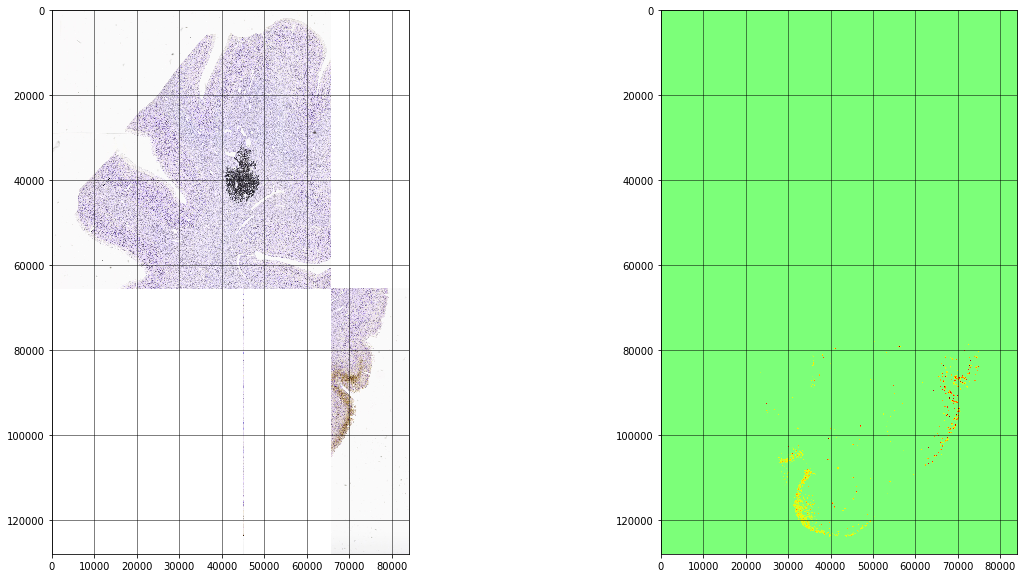

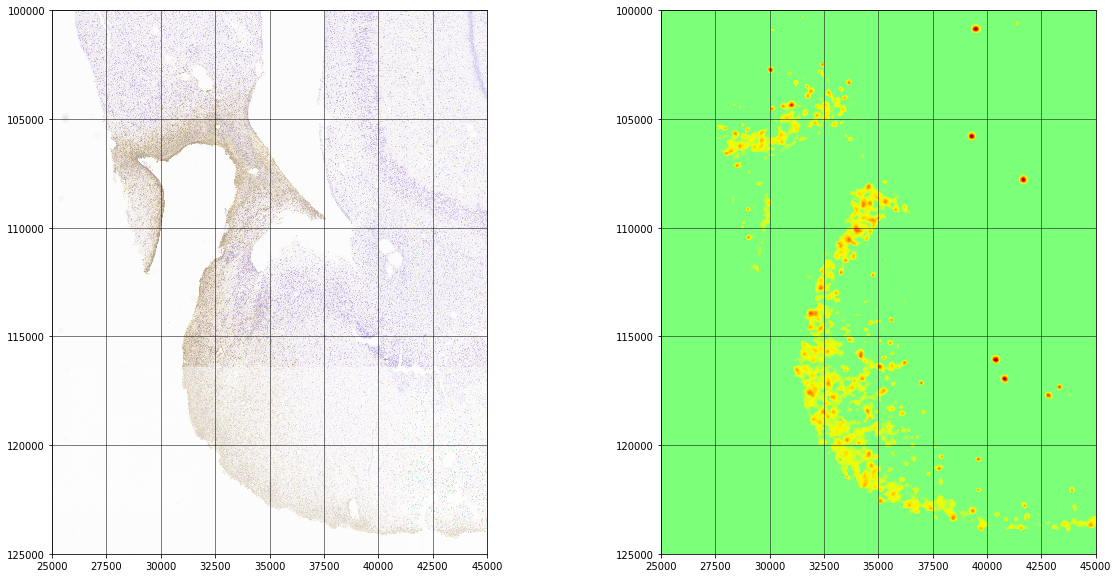

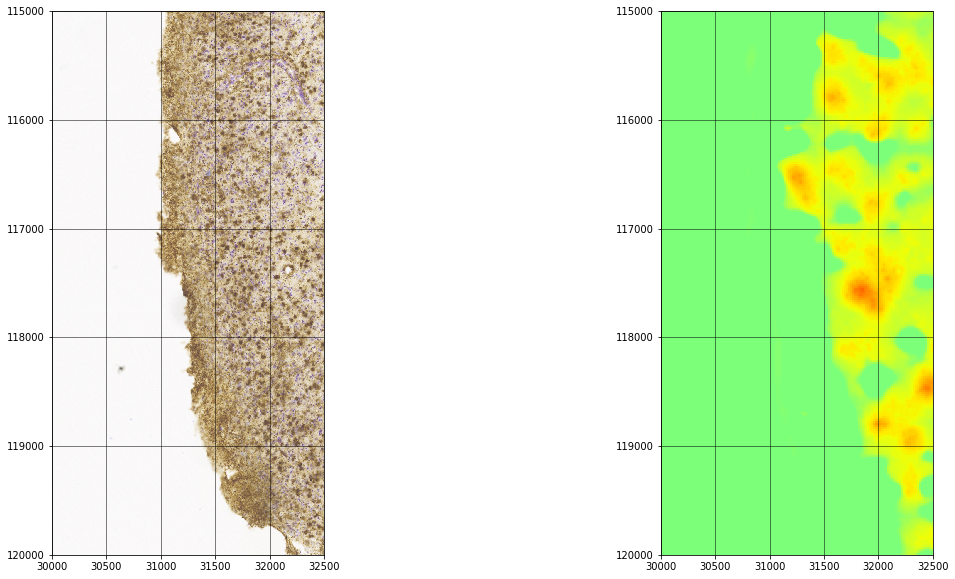

In [58]:
plot_classification_region(0,0,slide_dim[0],slide_dim[1],4)
plot_classification_region(25000,100000,45000,125000,2)

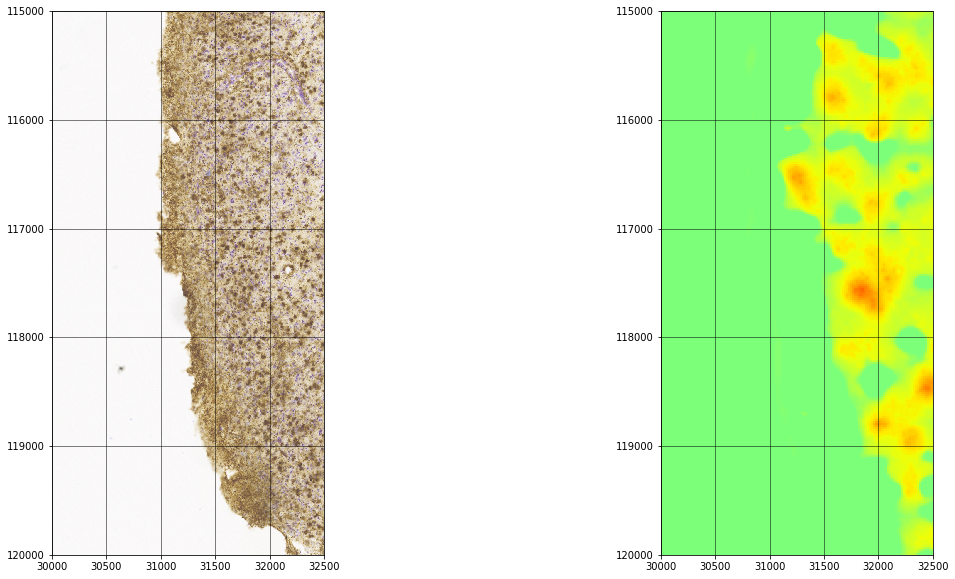

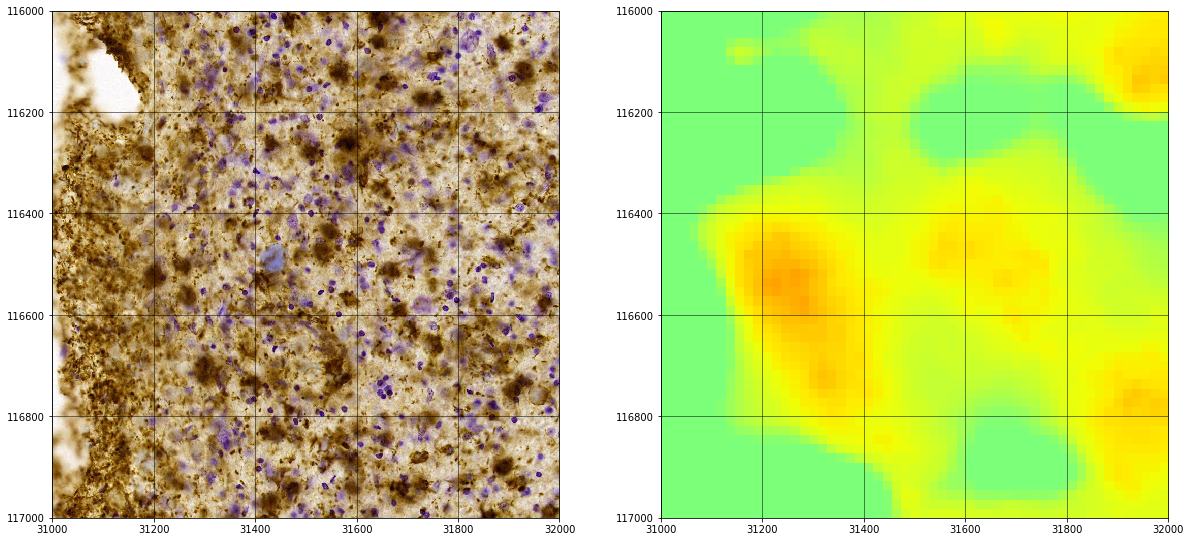

In [59]:
plot_classification_region(30000,115000,32500,120000,1)
plot_classification_region(31000,116000,32000,117000,0)